In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import os
import shapely
# import geopandas as gpd

import skimage as ski
from skimage.morphology import dilation, square
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
kp_dir = r"pred_labels\keypoints"
sg_dir = r"pred_labels\segments"
im_dir = r"depth_images"
out_dir = r"results"
cow_list = os.listdir(im_dir)

In [3]:
def mk_dir(dirpath):
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)
        
def area_ratio(labels):
    values = np.max(labels)
    areas = []
    for value in range(values):
        area = len(labels[labels==value+1])
        areas.append(area)
    return max(areas)/min(areas)

In [5]:
dil_factor = 30
ratio_limit = 4
iter_limit = 5

for cow in cow_list:
    filenames = os.listdir(os.path.join(im_dir, cow))
    out_path = os.path.join(out_dir, cow)
    mk_dir(out_path)
    for file in filenames:
        label = file.replace(".tif", ".txt")
        udder = ski.io.imread(os.path.join(im_dir, cow, file))
        # image shape is in y,x oder
        im_size = udder.shape
        im_height = im_size[0]
        im_width = im_size[1]

        # segments are in x,y oder 
        with open(os.path.join(sg_dir, label), "r") as f:
            mask = np.array([float(point) for point in f.read().split(" ")][1:])
        mask = mask.reshape((int(len(mask)//2),2))

        # keypoints are in x,y oder
        with open(os.path.join(kp_dir, label), "r") as f:
            data =  [float(point) for point in f.read().split(" ")]
            box = np.array(data[1:5])
            points = np.array(data[5:])
        points = points.reshape((4,3))
        box = box.reshape((2,2))
        box[:, 0] = box[:, 0] * im_width
        box[:, 1] = box[:, 1] * im_height
        box[0, 0] = box[0, 0] - box[1, 0]/2
        box[0, 1] = box[0, 1] - box[1, 1]/2

        points[:, 0] = points[:, 0] * im_width
        points[:, 1] = points[:, 1] * im_height

        # polygon requires y,x order
        ploygon = [[coord[1] * im_height, coord[0]*im_width] for coord in mask]
        mask2 = ski.draw.polygon2mask(im_size, ploygon)
        masked_udder = udder*mask2

        msk1 = [[coord[0]*im_width, coord[1] * im_height] for coord in mask]
        mask1 = np.zeros(im_size)

        points2 =np.round(points,0).astype(int)

        # location of teats
        rf_point = shapely.Point(points[0, :2])
        lf_point = shapely.Point(points[1, :2])
        rb_point = shapely.Point(points[2, :2])
        lb_point = shapely.Point(points[3, :2])

        udder_shp = shapely.Polygon(msk1)

        wd_front = shapely.distance(rf_point, lf_point)
        wd_back = shapely.distance(rb_point, lb_point)

        rf_ud = shapely.distance(udder_shp.exterior, rf_point)
        lf_ud = shapely.distance(udder_shp.exterior, lf_point)
        rb_ud = shapely.distance(udder_shp.exterior, rb_point)
        lb_ud = shapely.distance(udder_shp.exterior, lb_point)

        distances = {"wd_front": wd_front, "wd_back": wd_back, "rf_ud": rf_ud, "lf_ud":lf_ud, "rb_ud": rb_ud, "lb_ud": lb_ud}

        col = ".r"
        # if they are too close to each other move 10 units away 
        cnt = 0       
        while (wd_front < min(box[1, 0],  box[1, 1])/2) & (cnt < iter_limit):
            # then move 20 appart
            angle = np.arccos(np.dot(rf_point.coords[0],lf_point.coords[0])/(np.linalg.norm(rf_point.coords[0]) * np.linalg.norm(lf_point.coords[0])))
            nrf_point = shapely.Point([rf_point.coords[0][0] + 30*np.cos(-angle), rf_point.coords[0][1] + 30*np.sin(-angle)])
            nlf_point = shapely.Point([lf_point.coords[0][0] - 30*np.cos(-angle), lf_point.coords[0][1] - 30*np.sin(-angle)])
            # make sure they are still inside the udder
            if udder_shp.contains(nrf_point):
                # update points 
                points2[0, :2] = np.round(nrf_point.coords[0], 0).astype(int)
            if udder_shp.contains(nlf_point):
                points2[1, :2] = np.round(nlf_point.coords[0], 0).astype(int)
            wd_front = shapely.distance(nrf_point, nlf_point)
            cnt +=1

        cnt = 0       
        while (wd_back < min(box[1, 0],  box[1, 1])/2) & (cnt < iter_limit):
            # then move 20 appart
            angle = np.arccos(np.dot(rb_point.coords[0],lb_point.coords[0])/(np.linalg.norm(rb_point.coords[0]) * np.linalg.norm(lb_point.coords[0])))
            nrb_point = shapely.Point([rb_point.coords[0][0] + 10*np.cos(-angle), rb_point.coords[0][1] + 10*np.sin(-angle)])
            nlb_point = shapely.Point([lb_point.coords[0][0] - 10*np.cos(-angle), lb_point.coords[0][1] - 10*np.sin(-angle)])
            # make sure they are still inside the udder
            if udder_shp.contains(nrb_point):
                # update points 
                points2[2, :2] = np.round(nrb_point.coords[0], 0).astype(int)
            if udder_shp.contains(nlb_point):
                points2[3, :2] = np.round(nlb_point.coords[0], 0).astype(int)

            wd_back = shapely.distance(nrb_point, nlb_point)
            cnt +=1
        # if they are too close to the edge of the box move 10 units inside


        # marker locations
        mask1[points2[0, 1], points2[0,0]] = True
        mask1[points2[1, 1], points2[1,0]] = True
        mask1[points2[2, 1], points2[2,0]] = True
        mask1[points2[3, 1], points2[3,0]] = True

        mask1 = dilation(mask1,  square(dil_factor))
        markers, _ = ndi.label(mask1)
        # find segments
        labels = watershed(masked_udder, markers = markers, mask = mask2, watershed_line=True)

        # area of labels
        ratio = area_ratio(labels)

        cnt = 0
        print(f"{cnt} cow: {cow}, ratio: {ratio}")

        while (ratio > ratio_limit) & (cnt < iter_limit): # and the number of segements is 4
            mask1 = dilation(mask1,  square(10))
            markers, _ = ndi.label(mask1)
            labels2 = watershed(masked_udder, markers = markers, mask = mask2, watershed_line=True)
            num_segments = np.max(labels2)
            if num_segments < 4:
                break
            else:
                labels = labels2
            ratio = area_ratio(labels)
            num_segments = np.max(labels2)
            cnt +=1
            print(f"\t {cnt} cow: {cow}, ratio: {ratio}")

        # make a nice plot!
        fig, ax = plt.subplots()
        ax.imshow(labels, cmap=plt.cm.nipy_spectral)
        ax.plot(points2[0, 0], points2[0, 1], col) # right front
        ax.plot(points2[1, 0], points2[1, 1], col) # left front
        ax.plot(points2[2, 0], points2[2, 1], col) # right back
        ax.plot(points2[3, 0], points2[3, 1], col) # left back

        fig.savefig(os.path.join(out_path, file.replace("tif", "png")))
        plt.close(fig)   

0 cow: 1023, ratio: 1.447459372012648
0 cow: 1023, ratio: 1.4479395085066162
0 cow: 1023, ratio: 1.4770290964777948
0 cow: 1023, ratio: 1.5348998995130247
0 cow: 1023, ratio: 1.777707369621697
0 cow: 1023, ratio: 1.4174647462483976
0 cow: 1023, ratio: 1.4174131931591027
0 cow: 1023, ratio: 1.5661792850034448
0 cow: 1023, ratio: 1.4846907993966818
0 cow: 1023, ratio: 1.3835060838215412
0 cow: 1023, ratio: 41.9188679245283
0 cow: 1023, ratio: 1.3344165435745938
0 cow: 1023, ratio: 1.2721295248868778
0 cow: 1023, ratio: 1.3323269355186542
0 cow: 1023, ratio: 1.54212155776438
0 cow: 1023, ratio: 31.402275077559462
0 cow: 1023, ratio: 1.3126033503486951
0 cow: 1023, ratio: 1.7884674874713853
0 cow: 1023, ratio: 1.5620410036719705
0 cow: 1023, ratio: 1.3150695115604787
0 cow: 1023, ratio: 1.451261557749569
0 cow: 1023, ratio: 1.645794163328701
0 cow: 1023, ratio: 1.353732245391357
0 cow: 1023, ratio: 1.3299228944246737
0 cow: 1023, ratio: 1.5172065563582693
0 cow: 1023, ratio: 1.498354231974

In [ ]:
# def sep_points(right_kp, left_kp, udder_shp):
    
    
# angle = np.arccos(np.dot(rb_point.coords[0],lb_point.coords[0])/(np.linalg.norm(rb_point.coords[0]) * np.linalg.norm(lb_point.coords[0])))
# nrb_point = shapely.Point([rb_point.coords[0][0] + 10*np.cos(-angle), rb_point.coords[0][1] + 10*np.sin(-angle)])
# nlb_point = shapely.Point([lb_point.coords[0][0] - 10*np.cos(-angle), lb_point.coords[0][1] - 10*np.sin(-angle)])
# # make sure they are still inside the udder
# if udder_shp.contains(nrb_point):
#     # update points 
#     points2[2, :2] = np.round(nrb_point.coords[0], 0).astype(int)
# if udder_shp.contains(nlb_point):
#     points2[3, :2] = np.round(nlb_point.coords[0], 0).astype(int)

In [7]:
import geopandas as gpd
rf_point = shapely.Point(points[0, :2])
lf_point = shapely.Point(points[1, :2])
rb_point = shapely.Point(points[2, :2])
lb_point = shapely.Point(points[3, :2])

udder_shp = shapely.Polygon(msk1)

wd_front = shapely.distance(rf_point, lf_point)
wd_back = shapely.distance(rb_point, lb_point)

rf_ud = shapely.distance(udder_shp.exterior, rf_point)
lf_ud = shapely.distance(udder_shp.exterior, lf_point)
rb_ud = shapely.distance(udder_shp.exterior, rb_point)
lb_ud = shapely.distance(udder_shp.exterior, lb_point)

distances = {"wd_front": wd_front, "wd_back": wd_back, "rf_ud": rf_ud, "lf_ud":lf_ud, "rb_ud": rb_ud, "lb_ud": lb_ud}

<Axes: >

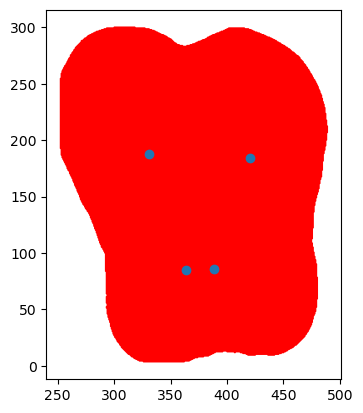

In [12]:
# obj = gpd.GeoSeries(box_polygon)
pts = gpd.GeoSeries([rf_point, lf_point, rb_point, lb_point])
msk = gpd.GeoSeries(udder_shp)
# nf = gpd.GeoSeries([new_point1, new_point2])
# box_polygon.contains(lf_point)

figure, ax = plt.subplots()
# p.plot(ax = ax)
msk.plot(ax = ax, color = "red")
pts.plot(ax = ax)
# nf.plot(ax = ax)

In [146]:
angle = np.arccos(np.dot(rf_point.coords[0],lf_point.coords[0])/(np.linalg.norm(rf_point.coords[0]) * np.linalg.norm(lf_point.coords[0])))
nrf_point = shapely.Point([rf_point.coords[0][0] + 30*np.cos(-angle), rf_point.coords[0][1] + 30*np.sin(-angle)])
nlf_point = shapely.Point([lf_point.coords[0][0] - 30*np.cos(-angle), lf_point.coords[0][1] - 30*np.sin(-angle)])